In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    BertTokenizer,
    BertModel,
    AdamW,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from datasets import load_dataset
from sklearn.preprocessing import normalize

c:\Users\timashan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data


In [38]:
base_data_path = "../../data/I-created/amazon-scrape-4-llm/"
df_train = pd.read_csv(base_data_path + "amazon.csv")
df_test = pd.read_csv(base_data_path + "laptops.csv")

train_texts, train_labels = df_train.to_dict("list").values()
val_texts, val_labels = df_test.to_dict("list").values()

In [39]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label),
        }

In [40]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [41]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(
        actual_labels, predictions
    )

In [42]:
def train(model, data_loader, optimizer, scheduler, device):
    losses = []
    model.train()
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
    return losses

In [53]:
def predict(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(
        text,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return preds.item()

In [44]:
bert_model_name = "bert-base-uncased"
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(
    train_texts, train_labels, tokenizer, max_length
)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [46]:
losses = []
train_accuracies = []
val_accuracies = []
lrs = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier("bert-base-uncased", 2).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=2e-3)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [47]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    losses += train(model, train_dataloader, optimizer, scheduler, device)
    train_accuracy, train_report = evaluate(model, train_dataloader, device)
    val_accuracy, report = evaluate(model, val_dataloader, device)
    train_accuracies.extend([train_accuracy] * len(train_dataloader))
    val_accuracies.extend([val_accuracy] * len(train_dataloader))
    lrs.append(optimizer.param_groups[0]["lr"])
    print(
        f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, loss: {losses[-1]}"
    )

Epoch 1/4


100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Train Accuracy: 0.7017, Val Accuracy: 0.6427, loss: 0.28742045164108276
Epoch 2/4


100%|██████████| 30/30 [00:07<00:00,  4.17it/s]


Train Accuracy: 0.9292, Val Accuracy: 0.8784, loss: 0.2414979487657547
Epoch 3/4


100%|██████████| 30/30 [00:07<00:00,  4.16it/s]


Train Accuracy: 0.9721, Val Accuracy: 0.9380, loss: 0.06044692546129227
Epoch 4/4


100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


Train Accuracy: 0.9764, Val Accuracy: 0.9404, loss: 0.04223691672086716


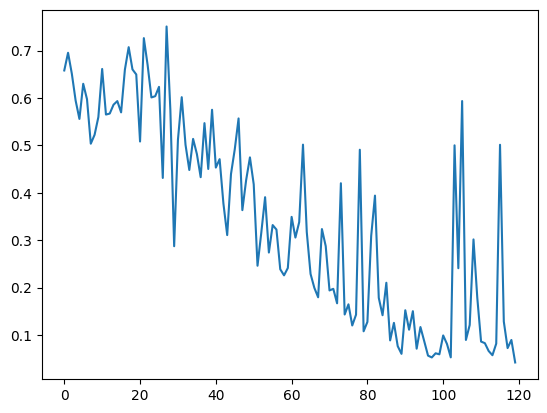

In [48]:
plt.plot(range(len(losses)), losses)

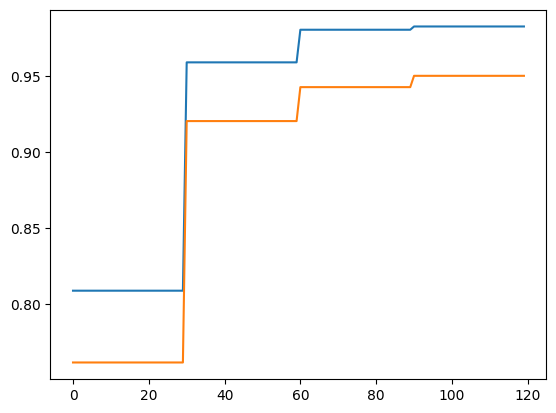

In [17]:
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(train_accuracies)), val_accuracies)